In [1]:
# Import libraries
import mne
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Sklearn library
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import ShuffleSplit, cross_val_score, StratifiedShuffleSplit, train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeClassifier
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.metrics import accuracy_score, ConfusionMatrixDisplay

# Pyriemann library
from pyriemann.tangentspace import TangentSpace
from pyriemann.estimation import Covariances
from pyriemann.estimation import ERPCovariances, XdawnCovariances
from pyriemann.classification import MDM, TSclassifier
from pyriemann.estimation import ERPCovariances, XdawnCovariances


# Other imports

from imblearn.under_sampling import InstanceHardnessThreshold
mne.viz.set_browser_backend('matplotlib', verbose=None)
from collections import OrderedDict
from mne.decoding import Vectorizer

Using matplotlib as 2D backend.


In [2]:
def pyriemann_pipeline(epoch):
    clfs = OrderedDict()
    clfs['Vect + LR'] = make_pipeline(Vectorizer(), StandardScaler(with_mean=True, with_std=True), LogisticRegression(max_iter=1000))
    clfs['Vect + RegLDA'] = make_pipeline(Vectorizer(), LDA(shrinkage='auto', solver='eigen'))
    clfs['ERPCov + MDM'] = make_pipeline(ERPCovariances(estimator='oas', classes=[0]), MDM())
    clfs['XdawnCov + MDM'] = make_pipeline(XdawnCovariances(nfilter=2, applyfilters=True, classes=[0], estimator='lwf', xdawn_estimator='lwf', baseline_cov=None), MDM())
    clfs['XdawnCov + Vect + LR'] = make_pipeline(XdawnCovariances(nfilter=2, applyfilters=True, classes=None, estimator='lwf', xdawn_estimator='lwf', baseline_cov=None), Vectorizer(), StandardScaler(with_mean=True, with_std=True), LogisticRegression(max_iter=1000))

    X = epoch.get_data() * 1e6  
    epoch.pick_types(eeg=True)
    y = epoch.events[:, -1]
    y = LabelEncoder().fit_transform(y)
    
    n_epochs, channels, time = X.shape
    X_reshaped = X.reshape(n_epochs, channels * time)
    scaler = StandardScaler()
    normalized_features = scaler.fit_transform(X_reshaped)
    iht = InstanceHardnessThreshold(random_state=42)
    X_balanced, y_balanced = iht.fit_resample(X_reshaped, y)
    X_balanced_data = X_balanced.reshape(-1, channels, time)

    cv = StratifiedShuffleSplit(n_splits=10, test_size=0.30, random_state=42)
    
    auc = []
    methods = []
    
    for m in clfs:
        try:
            res = cross_val_score(clfs[m], X_balanced_data, y_balanced, scoring='roc_auc_ovr', cv=cv, n_jobs=-1)
            auc.extend(res)
            methods.extend([m] * len(res))
        except Exception as e:
            print(f"Error evaluating {m}: {e}")

    clfz = OrderedDict()
    clfz['ERPCov + TS + SVC'] = make_pipeline(ERPCovariances(estimator='oas'), TangentSpace(metric="riemann"), StandardScaler(), SVC(kernel='linear', C=1.0))
    clfz['XdawnCov + TS + SVC'] = make_pipeline(XdawnCovariances(nfilter=2, applyfilters=True, classes=None, estimator='lwf', xdawn_estimator='lwf', baseline_cov=None), TangentSpace(), StandardScaler(), SVC(kernel='linear', C=1.0))
    clfz["tgsp + svm"] = make_pipeline(Covariances("lwf"), TangentSpace(metric="riemann"), StandardScaler(), SVC())
    for name, clf in clfz.items():
        for train_idx, test_idx in cv.split(X_balanced_data, y_balanced):
            y_train, y_test = y_balanced[train_idx], y_balanced[test_idx]
            clf.fit(X_balanced_data[train_idx], y_train)
            preds = clf.predict(X_balanced_data[test_idx])
            fold_accuracy = np.mean(preds == y_test)
            auc.append(fold_accuracy)
            methods.append(name)
    
    clfs.update(clfz)

    return auc, methods, X_balanced_data, y_balanced, clfs


In [3]:
def classifier_pipeline(epochs):
    tmin, tmax = 0.3, 0.6
    epochs_crop = epochs.get_data()[:, :, int(epochs.time_as_index(tmin)):int(epochs.time_as_index(tmax))]
    channels_of_interest = ['P3', 'P4', 'Pz','P7','P8','PO3','POz','PO4','PO7','PO8','Oz','O1','O2']
    peak_amplitudes = {ch: [] for ch in channels_of_interest}
    
    for ch in channels_of_interest:
        ch_idx = epochs.info['ch_names'].index(ch)  
        for epoch_data in epochs_crop:
            time_max = np.argmax(epoch_data[ch_idx, :])
            peak_amplitude = epoch_data[ch_idx, time_max]
            peak_amplitudes[ch].append(peak_amplitude)
    label = epochs.events[:, -1]
    le= LabelEncoder()
    y_label = le.fit_transform(label)
    feature_matrix = np.vstack([peak_amplitudes[ch] for ch in channels_of_interest]).T

    scaler = StandardScaler()
    normalized_features = scaler.fit_transform(feature_matrix)
    iht = InstanceHardnessThreshold(random_state=0,
                      estimator=LogisticRegression(
                         solver='lbfgs', multi_class='auto'))
    X_resampled, y_resampled = iht.fit_resample(normalized_features, y_label)
    clf1 = LogisticRegression()
    clf2 = RandomForestClassifier()
    clf3 = GaussianNB()
    clf4 = SVC()
    clf5 = DecisionTreeClassifier (max_depth =6)
    clf6 = LDA(solver='lsqr',shrinkage=0.5)
    clf7 = KNeighborsRegressor(n_neighbors=1)
    clf8 = QuadraticDiscriminantAnalysis()
    classifiers_names = ['Logistic Regression','Random Forest Classifier','GaussianNB','SVC', 'Decision Tree Classifier', 
                         'LDA', 'KNeighborsRegressor','Quadratic Discriminant Analysis']
    cv = StratifiedShuffleSplit(n_splits=10, test_size=0.25, 
                            random_state=42)
    classifiers = [clf1, clf2, clf3, clf4, clf5, clf6, clf7, clf8]
    accuracies=[]
    method=[]
    accuracy =[]
    for clf, clfs_name in zip(classifiers, classifiers_names):
        acc = cross_val_score(clf, X_resampled, y_resampled==0, scoring='roc_auc',cv=cv) 
        accuracies.append(acc)
        accuracy.extend(acc)
        method.extend([clfs_name]*len(acc))
        for train_index, test_index in cv.split(X_resampled, y_resampled):
            X_train, X_test = X_resampled[train_index], X_resampled[test_index]
            y_train, y_test = y_resampled[train_index], y_resampled[test_index]
            clf.fit(X_train, y_train)
            y_pred = clf.predict(X_test)
    return accuracy, method, classifiers, classifiers_names, X_resampled, y_resampled

In [4]:
def pyriemann_pipeline_plot(auc, methods, X_balanced_data, y_balanced, clfs):
    results = pd.DataFrame(data=auc, columns=['AUC'])
    results['Method'] = methods
    plt.figure(figsize=[8,4])
    sns.barplot(data=results, x='AUC', y='Method')
    plt.xlim(0.3, 0.95)
    sns.despine()
    X_train, X_test, y_train, y_test = train_test_split(X_balanced_data, y_balanced, test_size=0.30, random_state=42)
    plt.figure(figsize=(16, 8))  
    for i, (m, clf) in enumerate(clfs.items()):
        try:
            clf.fit(X_train, y_train)
            y_pred = clf.predict(X_test)
            conf_matrix = confusion_matrix(y_test, y_pred)
            plt.subplot(3, 3, i+1)
            sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=True, xticklabels=["target", "distractors", "n-target"], yticklabels=["target", "distractors","n-target"])
            plt.title(f'Confusion Matrix - {m}')
            plt.xlabel('Predicted label')
            plt.ylabel('True label')
        except Exception as e:
            print(f"Error occurred for {m}: {str(e)}")
    plt.tight_layout()
    plt.show()

In [5]:
def classification_pipeline_plot(accuracy, method, classifiers, classifiers_names, X_resampled, y_resampled):
    result = pd.DataFrame(data=accuracy, columns=['AUC'])
    result['Method'] = method
    fig = plt.figure(figsize=[8,4])
    sns.barplot(data=result, x='AUC', y='Method')
    plt.xlim(0.3, 1.0)
    sns.despine()
    num_rows = 3
    num_cols = 3
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(16, 8))
    for i, (clf, clf_name) in enumerate(zip(classifiers, classifiers_names)):
        if i >= num_rows * num_cols:
            break  
        ax = axes.flatten()[i]
        X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.30, random_state=42)
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        cm = confusion_matrix(y_test, y_pred)
        if np.sum(cm) > 0:
            sns.heatmap(cm, annot=True, cmap='Blues', fmt='d', ax=ax, xticklabels=["target", "distractors","n-target"], yticklabels=["target", "distractors", "n-target"])
            ax.set_title(f'Confusion Matrix - {clf_name}')
            ax.set_xlabel('Predicted Label')
            ax.set_ylabel('True Label')
        else:
            ax.axis('off')
    for j in range(i+1, num_rows * num_cols):
        axes.flatten()[j].axis('off')
    plt.tight_layout()
    plt.show()

Reading C:\Users\neuramod\00674_S003_T001-epo.fif ...
    Found the data of interest:
        t =    -199.22 ...     800.78 ms
        0 CTF compensation matrices available
Not setting metadata
1423 matching events found
No baseline correction applied
0 projection items activated
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).


C:\Users\neuramod\AppData\Local\Temp\ipykernel_19908\1628549735.py:9: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  X = epoch.get_data() * 1e6
C:\Users\neuramod\AppData\Local\Temp\ipykernel_19908\382024416.py:3: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  epochs_crop = epochs.get_data()[:, :, int(epochs.time_as_index(tmin)):int(epochs.time_as_index(tmax))]


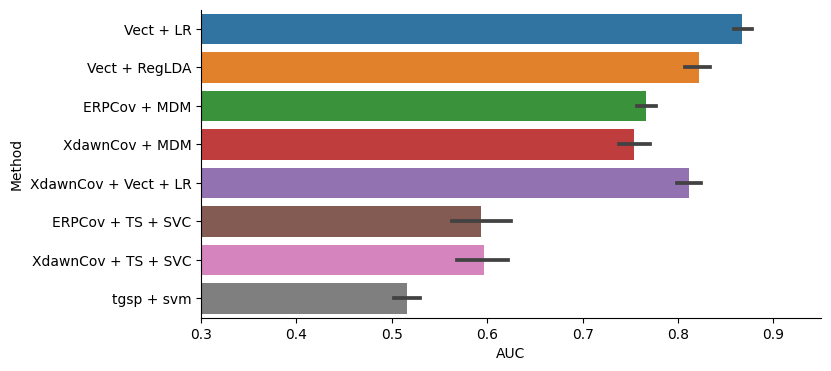

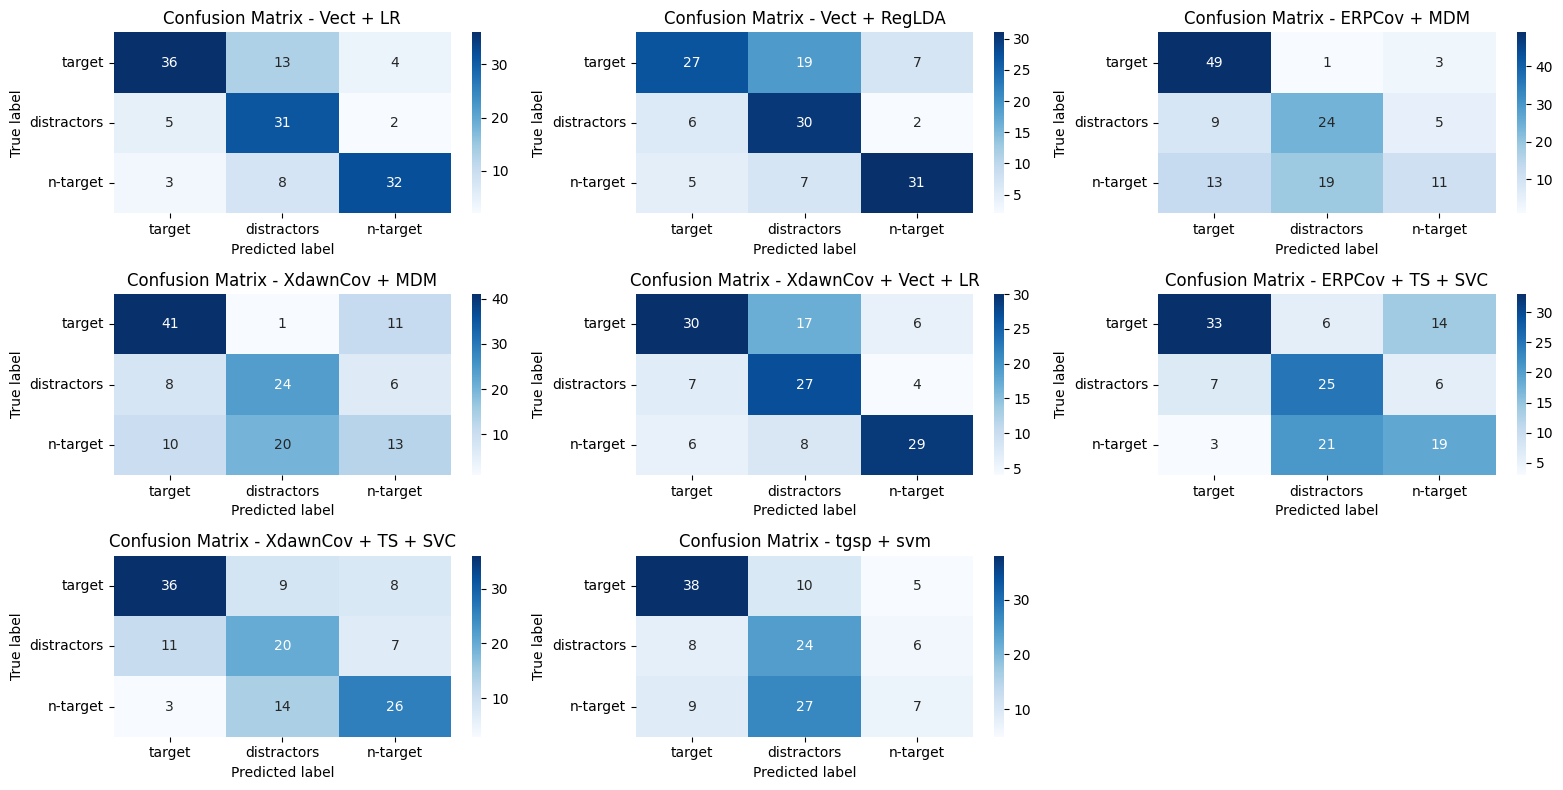

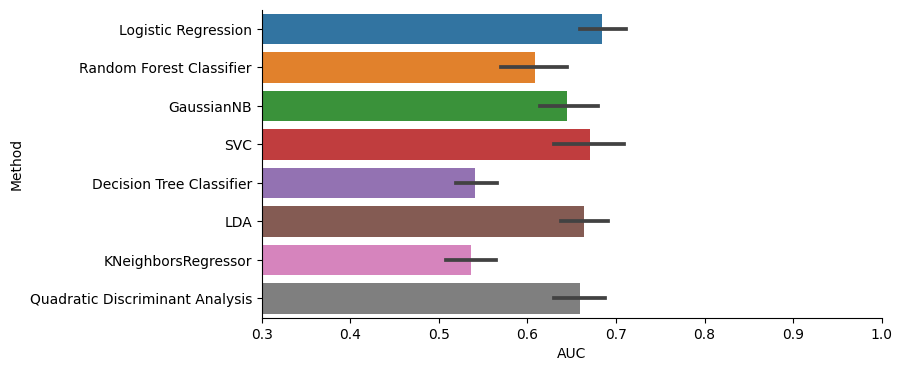

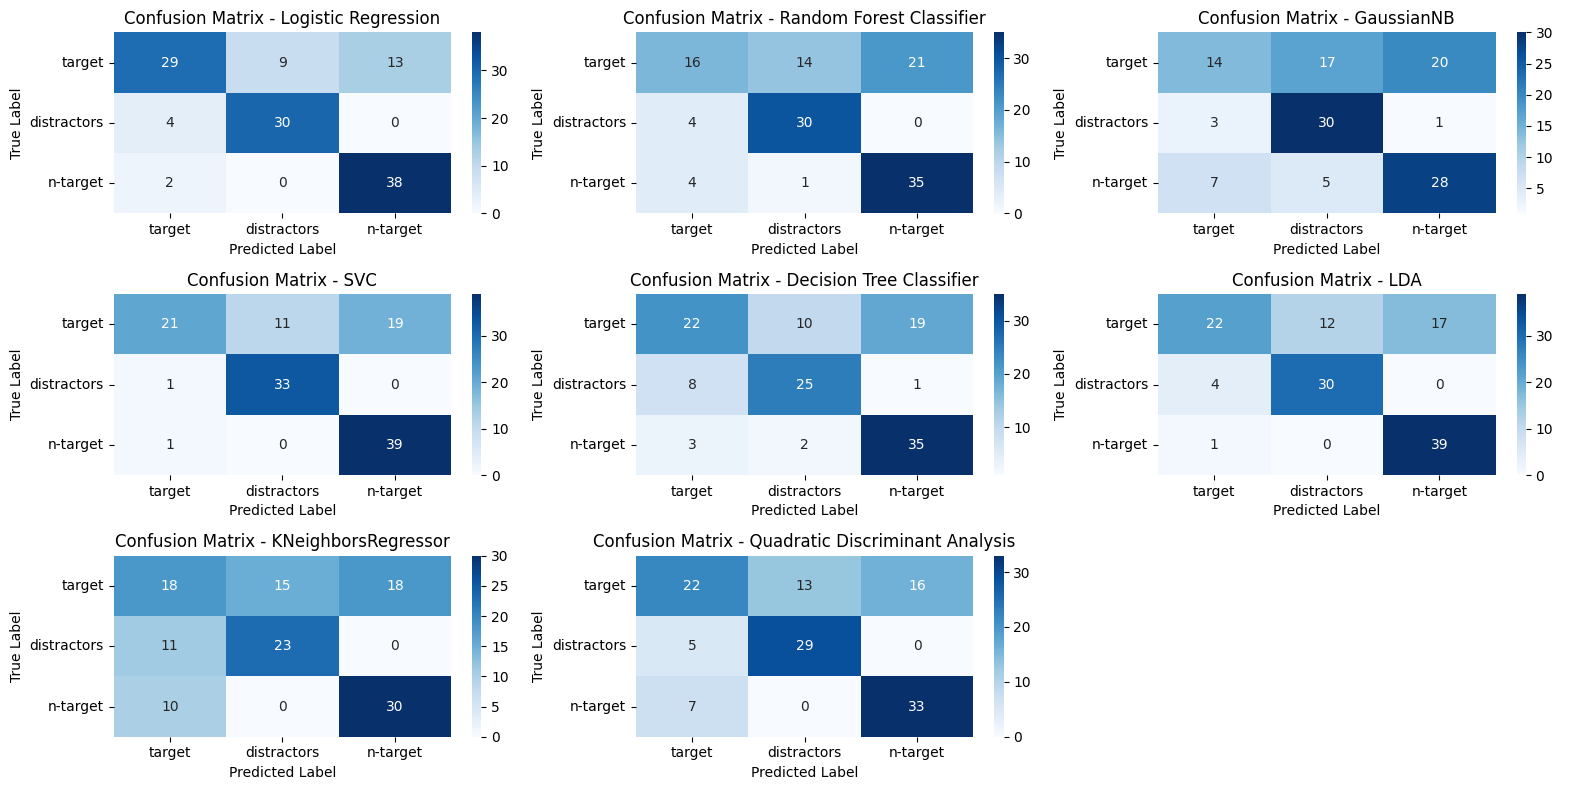

In [6]:
epoch_file = '00674_S003_T001-epo.fif'
epoch = mne.read_epochs(epoch_file)
auc, methods, X_balanced_data, y_balanced, clfs = pyriemann_pipeline(epoch)
accuracy, method, classifiers, classifiers_names, X_resampled, y_resampled = classifier_pipeline(epoch)
pyriemann_pipeline_plot(auc, methods, X_balanced_data, y_balanced, clfs)
classification_pipeline_plot(accuracy, method, classifiers, classifiers_names, X_resampled, y_resampled)